In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from astropy.io import fits, ascii
from astropy.table import Table
import os
import math

import TheCannon
from TheCannon import dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2016/bin/x86_64-darwin'

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_dir = '/home/jess/Desktop/Research/libraries/APOGEE-RAW/'
files = os.listdir(model_dir)

In [3]:
tlbls = [f.split('08_t')[1].split('_g')[0] for f in files]
llbls = [f.split('_g')[1].split('_z')[0] for f in files]
zlbls = [f.split('_z')[1].split('_en')[0] for f in files]

labels = np.array([tlbls, llbls, zlbls]).T

In [4]:
content = [ascii.read(model_dir + ff) for ff in files]

In [15]:
# wave = np.array([list(c['col1']) for c in content])
# fluxes = np.array([list(c['col2']) for c in content])

# bad_indices = []
# for i in range(len(fluxes)):
#     if len(fluxes[i]) != 20501:
#         bad_indices.append(i)
# print(len(bad_indices))

# for b in bad_indices:
#     fluxes[b] = fluxes[b][::2]
#     wave[b] = wave[b][::2]
    
# bad_indices = []
# for i in range(len(fluxes)):
#     if len(fluxes[i]) != 20501:
#         bad_indices.append(i)
# print(len(bad_indices))

# wl = np.array(wave[0])
# tr_ID = np.array(['BTSETTL08_{}_{}_{}'.format(lbl[0], lbl[1], lbl[2]) for lbl in labels])
# tr_flux = np.array([fl for fl in fluxes])
# tr_ivar = 100*np.ones([len(labels),len(wl)])
# tr_label = np.array([list(map(float, lbl)) for lbl in labels])

In [4]:
wl = np.load('norm_wave.npy')
tr_flux = np.load('pseudo_tr_flux.npy')
tr_ivar = np.load('pseudo_tr_ivar.npy')
tr_ID = np.array(['BTSETTL08_{}_{}_{}'.format(lbl[0], lbl[1], lbl[2]) for lbl in labels])
tr_label = np.array([list(map(float, lbl)) for lbl in labels])

In [7]:
# pseudo_tr_flux, pseudo_tr_ivar = ds.continuum_normalize_training_q(q=0.90, delta_lambda=50)
# contmask = ds.make_contmask(pseudo_tr_flux, pseudo_tr_ivar, frac=0.07)
# ds.set_continuum(contmask)
# cont = ds.fit_continuum(3, "sinusoid")
# norm_tr_flux, norm_tr_ivar, norm_test_flux, norm_test_ivar = ds.continuum_normalize(cont)

# ds.tr_flux = norm_tr_flux
# ds.tr_ivar = norm_tr_ivar
# ds.test_flux = norm_test_flux
# ds.test_ivar = norm_test_ivar

# np.save('norm_wave', ds.wl)
# np.save('norm_ivar', norm_tr_ivar)
# np.save('norm_flux', norm_tr_flux)

In [5]:
ds = dataset.Dataset(wl, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar) 

Loading dataset
This may take a while...


In [6]:
ds.set_label_names(['T_{eff}', '\log g', '[Fe/H]'])
# ds.diagnostics_ref_labels()

In [7]:
def fitCannonModel(ds, **kwargs):
    
    order = kwargs.get('order', 2)
    
    md = model.CannonModel(order, None)
    md.fit(ds)
    
    coeffs = md.coeffs
    md.infer_labels(ds)
    test_labels = ds.test_label_vals
    
    nlabels = test_labels.shape[1]
    
    scaled_labels = []
    for i in range(nlabels):
        p, s = _getPivotsAndScales(test_labels.T[i])
        slbl = [(t - p)/s for t in test_labels.T[i]]
        scaled_labels.append(slbl)
    
    label_vec = np.array([_get_lvec(lbl) for lbl in np.array(scaled_labels).T])
    label_vec = np.insert(label_vec, 0, 1, axis=1)
    
    synth_fluxes = np.dot(coeffs, label_vec.T).T
    
    return md, ds, synth_fluxes

def _getPivotsAndScales(label_vals):

    qs = np.percentile(label_vals, (2.5, 50, 97.5), axis=0)
    pivots = qs[1]
    scales = (qs[2] - qs[0])/4.
    
    return pivots, scales

def _get_lvec(labels):

    nlabels = len(labels)
    # specialized to second-order model
    linear_terms = labels 
    quadratic_terms = np.outer(linear_terms, 
                               linear_terms)[np.triu_indices(nlabels)]
    lvec = np.hstack((linear_terms, quadratic_terms))
    return lvec

In [8]:
md, d, f = fitCannonModel(ds)

Done training model. 
Inferring Labels


In [127]:
np.save('500k_coeffs', md.coeffs)
np.save('500k_pivots', md.pivots)
np.save('500k_scales', md.scales)
np.save('500k_wl', ds.wl)

In [9]:
zero_z = np.where(tr_label.T[2] == 0)
zlabels = tr_label[zero_z]
znames = tr_ID[zero_z]

zteff = tr_label.T[0][zero_z]
zlogg = tr_label.T[1][zero_z]
zfe_h = tr_label.T[2][zero_z]

zsynth = f[zero_z]
zflux = tr_flux[zero_z]

errors = []
for i in range(len(zsynth)):
    diff_array = zsynth[i] - zflux[i]
    avg_diff = np.std(diff_array)
    errors.append(avg_diff)
errors = np.array(errors)

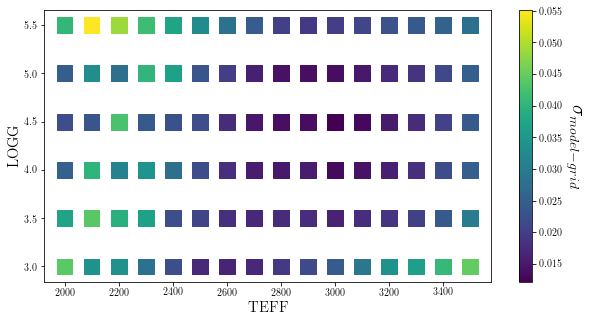

In [10]:
fig, ax = plt.subplots(figsize=[10,5])
plt.scatter(zteff, zlogg, c=errors, cmap='viridis', marker='s', s=250)
cbar = plt.colorbar()
cbar.set_label(r'$\sigma_{model - grid}$', size=20, rotation=270, va='bottom')
plt.xlabel('TEFF', fontsize=15)
plt.ylabel('LOGG', fontsize=15)
plt.show()

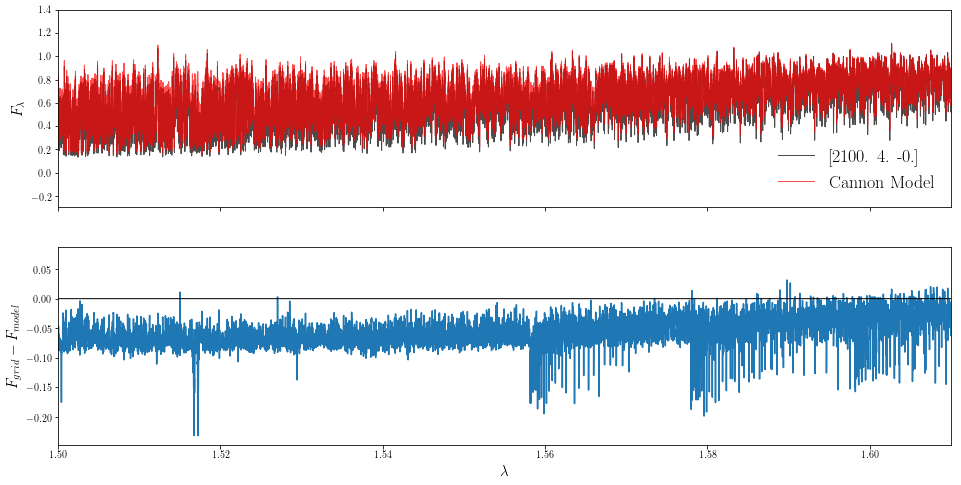

In [19]:
i = 200
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[16,8], sharex=True)
ax1.plot(wl, ds.tr_flux[i], label=str(tr_label[i]), color='k', linewidth=1, alpha=.7)
ax1.plot(wl, f[i], label='Cannon Model', color='r', linewidth=1, alpha=.7)
ax1.set_ylabel(r'$F_{\lambda}$', fontsize=15)
ax1.set_xlim(1.5, 1.61)
ax1.set_ylim(-.3,1.4)
ax1.legend(loc='lower right', frameon=False, fontsize=18)
ax2.plot(wl, ds.tr_flux[i] - f[i])
ax2.plot(wl, [0 for i in wl], color='k', linewidth=1)
ax2.set_xlabel('$\lambda$', fontsize=15)
ax2.set_ylabel(r'$F_{grid} - F_{model}$', fontsize=15)
plt.show()

In [12]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png
Diagnostic for label output vs. input
Saved fig 1to1_label_2.png
